In [2]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

data_path = "E:/Mouse_V1/"
adata_counts = sc.read_csv("E:/Mouse_V1/GSE190940_P28NR.csv")

sample_IDs = ["projection_seq", "P28_glut", "P28_gaba", "P28_non"] # 

accum_adata, cell_count = [], 0
for sample in sample_IDs:
    pre_path = data_path + sample + ".h5ad"
    temp_adata = sc.read_h5ad(
        pre_path,
                              )
    temp_adata.var_names_make_unique()
    if "P28" in sample:
        obs_names = [name[:29] for name in temp_adata.obs_names]
        X_counts = adata_counts[obs_names, temp_adata.var_names].X
        temp_adata.X = X_counts
    accum_adata.append(temp_adata)
    cell_count += temp_adata.n_obs

adata = accum_adata[0].concatenate(*accum_adata[1:], batch_categories=sample_IDs)
adata

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 30029 × 19728
    obs: 'batch', 'doublet', 'doublet_score', 'UPB1', 'UPB2', 'UPB4', 'UPB6', 'LM', 'RL', 'UPBs', 'VISs', 'n_genes', 'percent_mito', 'n_UMIs', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'
    var: 'feature_types', 'gene_ids-P28_gaba', 'n_cells-P28_gaba', 'highly_variable-0-P28_gaba', 'means-0-P28_gaba', 'dispersions-0-P28_gaba', 'dispersions_norm-0-P28_gaba', 'mean-0-P28_gaba', 'std-0-P28_gaba', 'highly_variable-1-P28_gaba', 'means-1-P28_gaba', 'dispersions-1-P28_gaba', 'dispersions_norm-1-P28_gaba', 'mean-1-P28_gaba', 'std-1-P28_gaba', 'highly_variable-2-P28_gaba', 'means-2-P28_gaba', 'dispersions-2-P28_gaba', 'dispersions_norm-2-P28_gaba', 'mean-2-P28_gaba', 'std-2-P28_gaba', 'highly_variable-3-P28_gaba', 'means-3-P28_gaba', 'dispersions-3-P28_gaba', 'dispersions_norm-3-P28_gaba', 'mean-3-P28_gaba', 'std-3-P28_gaba', 'highly_variable

In [15]:
dataset = []
for batch in adata.obs["batch"]:
    if "P28" in batch:
        dataset.append("Cell Paper")
    else:
        dataset.append("Projection-seq")
adata.obs["dataset"] = dataset

In [16]:
mask = np.array(np.isnan(adata.obs["UPB1"]))

for upb in ["UPB1", "UPB2", "UPB4", "UPB6"]:
    adata.obs.loc[mask, upb] = 0.0

In [17]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


2023-06-09 09:49:49,113 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-06-09 09:49:57,507 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-06-09 09:49:57,747 - harmonypy - INFO - Iteration 1 of 20
2023-06-09 09:50:12,295 - harmonypy - INFO - Iteration 2 of 20
2023-06-09 09:50:26,830 - harmonypy - INFO - Iteration 3 of 20
2023-06-09 09:50:41,442 - harmonypy - INFO - Converged after 3 iterations


computing neighbors


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


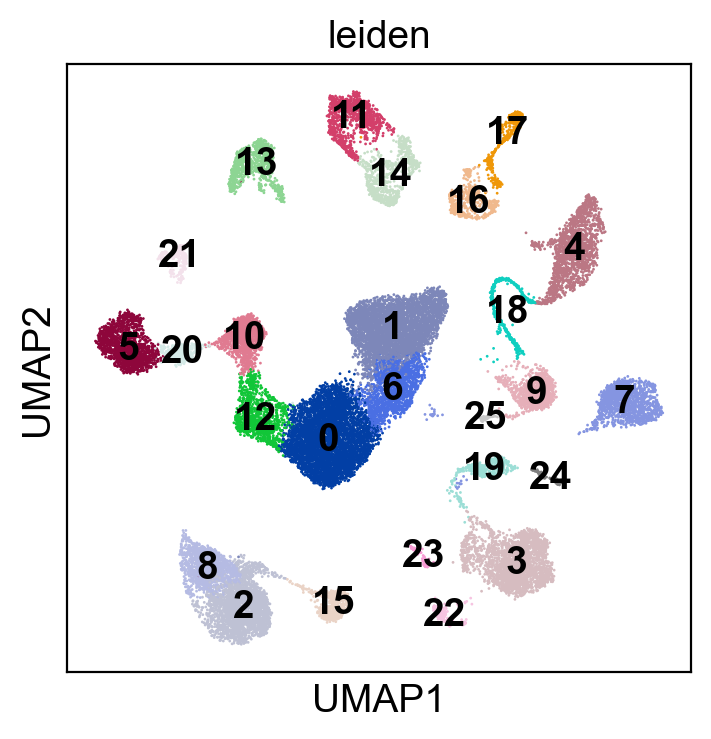

In [18]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, "dataset", max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata, key_added="leiden")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

In [2]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

adata = sc.read_h5ad("E:/Projection-Seq/anndata/Projection_Seq_P28_Glut_Mixed.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 19745 × 20620
    obs: 'batch', 'doublet', 'doublet_score', 'UPB1', 'UPB2', 'UPB4', 'UPB6', 'LM', 'RL', 'UPBs', 'VISs', 'n_genes', 'percent_mito', 'n_UMIs', 'n_counts', 'leiden', 'class', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'dataset', 'type'
    var: 'feature_types', 'gene_ids-P28_glut', 'n_cells-P28_glut', 'highly_variable-P28_glut', 'means-P28_glut', 'dispersions-P28_glut', 'dispersions_norm-P28_glut', 'mean-P28_glut', 'std-P28_glut', 'gene_ids-Projection_Seq_Glut', 'genome-Projection_Seq_Glut', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Subclass_colors', 'Type_colors', 'UPBs_colors', 'VISs_colors', 'dataset_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'subclass_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distance

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


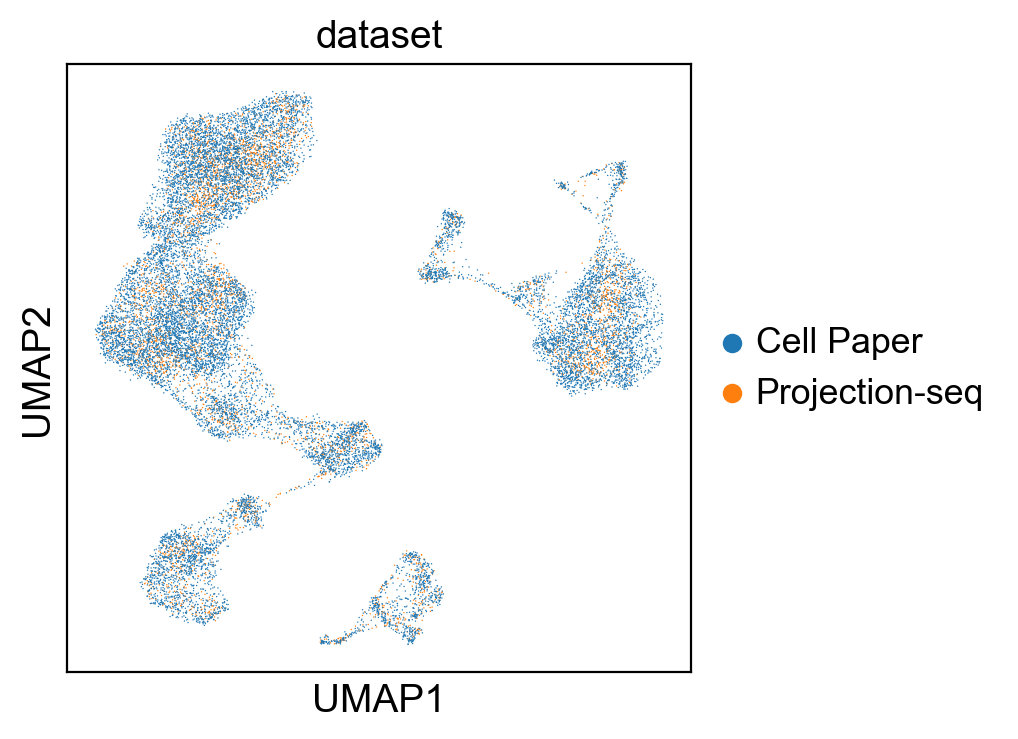

In [4]:
sc.pl.umap(adata, color=["dataset"], alpha=1, size=1)

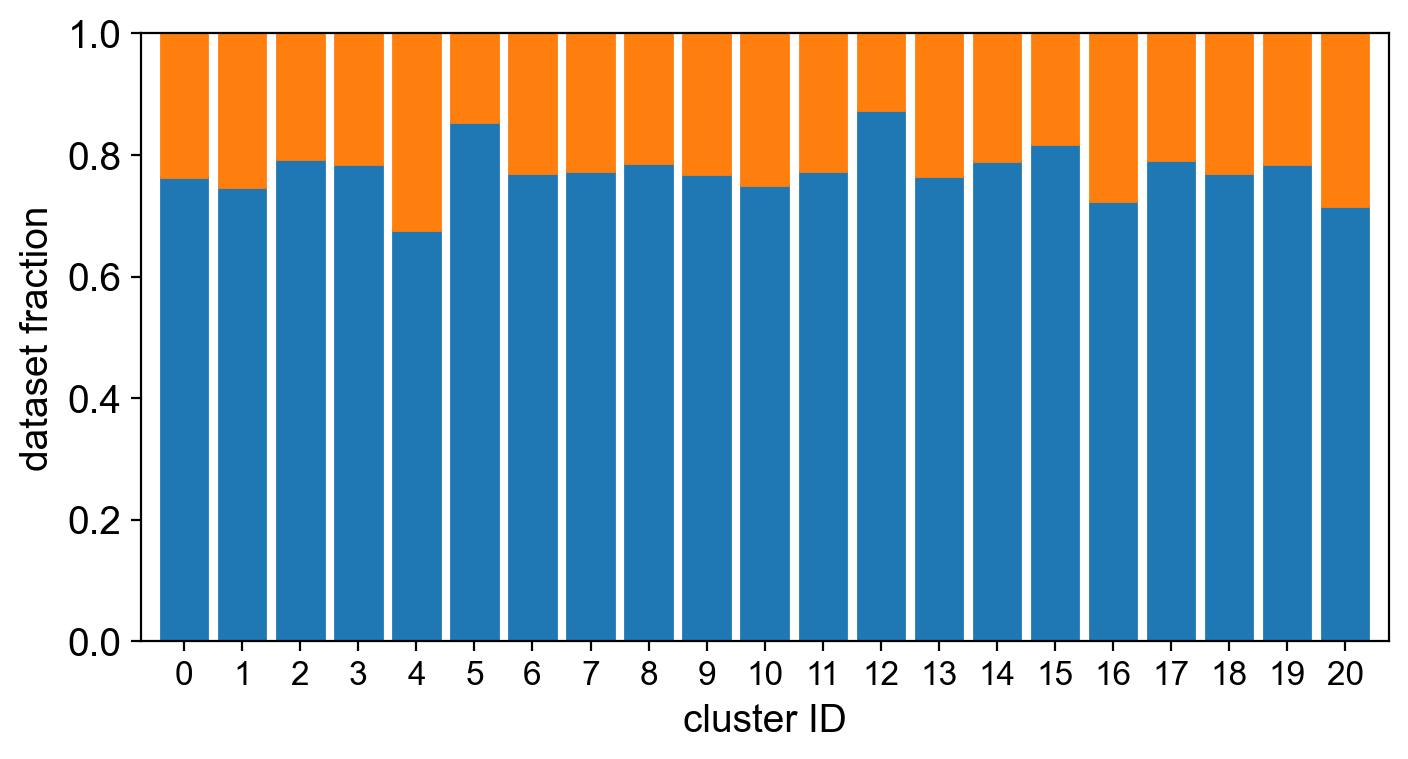

In [5]:
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
sample_fractions = []
for sample in ["Cell Paper", "Projection-seq"]:
    sf = []
    for cluster in cluster_ids:
        adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
        sf.append(np.sum(adata_clust.obs["dataset"] == sample) / adata_clust.shape[0])
    sample_fractions.append(sf)

fig, ax = plt.subplots()
bottom = np.zeros(len(cluster_ids))
for sf, col in zip(sample_fractions, adata.uns["dataset_colors"]):
    ax.bar(cluster_ids, sf, color=col, edgecolor=col, bottom=bottom)
    bottom += np.array(sf)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("dataset fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


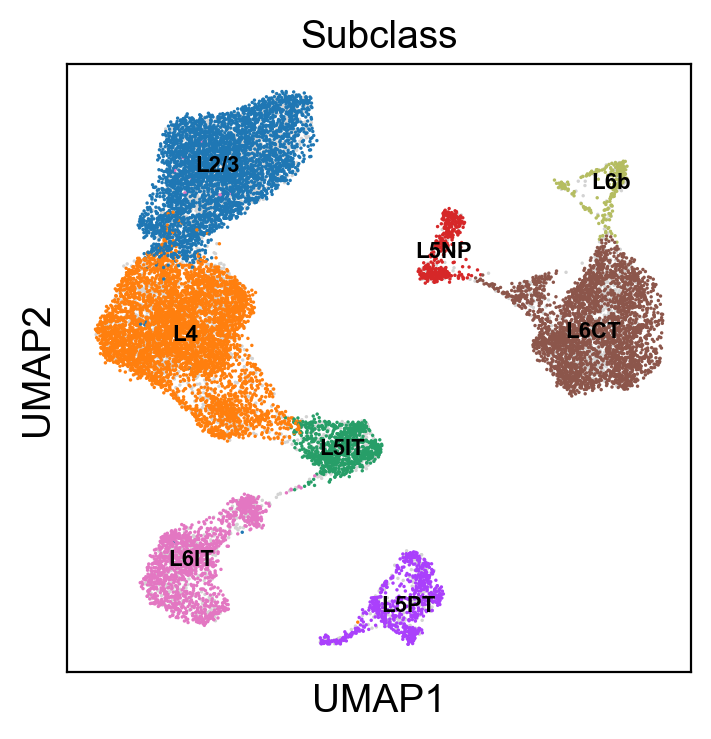

In [6]:
sc.pl.umap(adata, color=["Subclass"], legend_loc="on data", na_in_legend=False, legend_fontsize=8)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


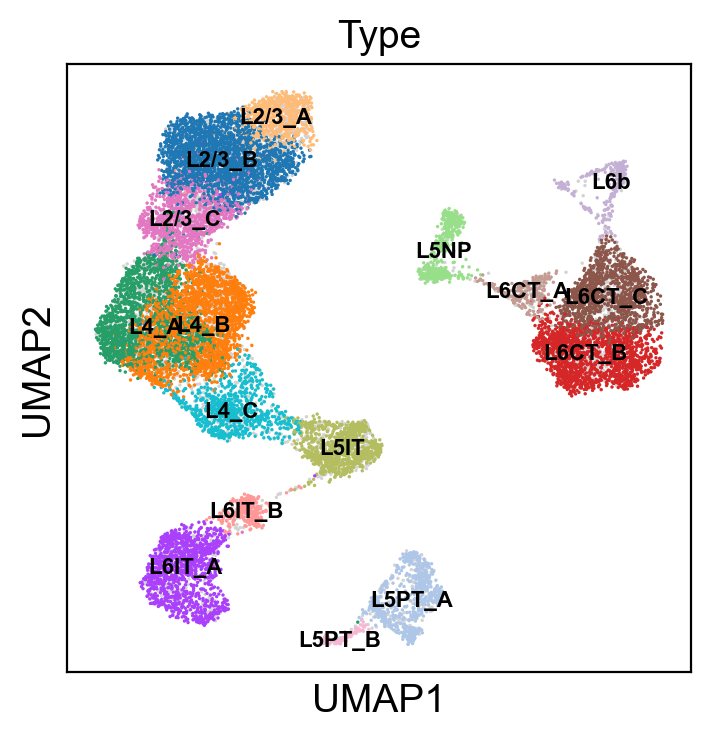

In [7]:
sc.pl.umap(adata, color=["Type"], legend_loc="on data", na_in_legend=False, legend_fontsize=8)

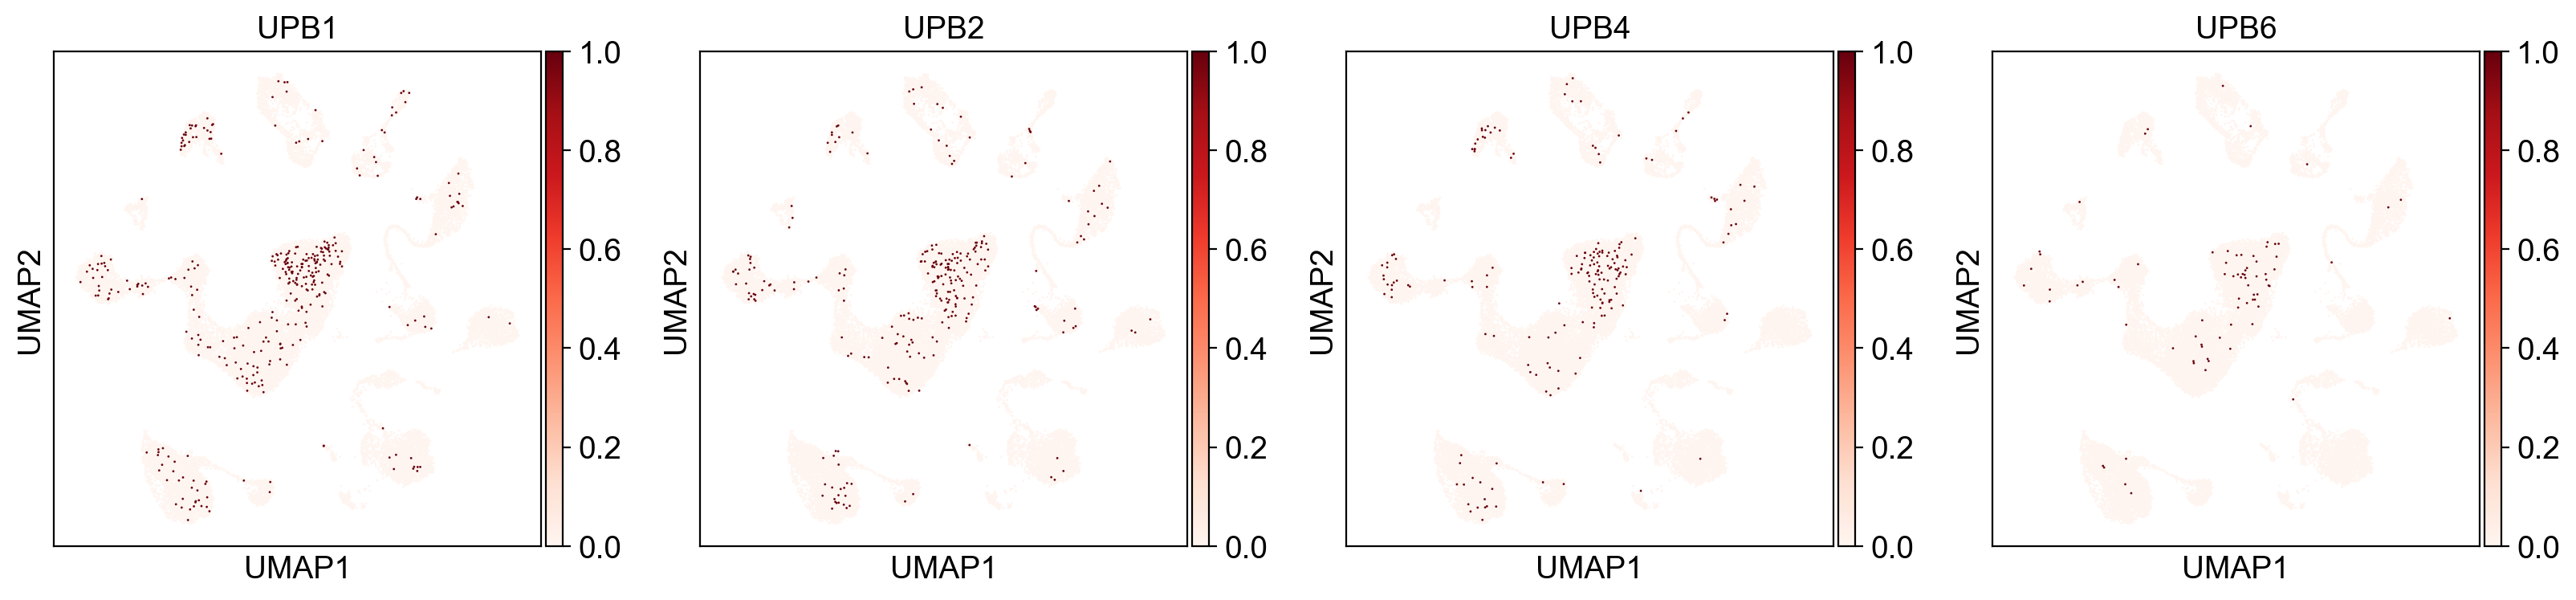

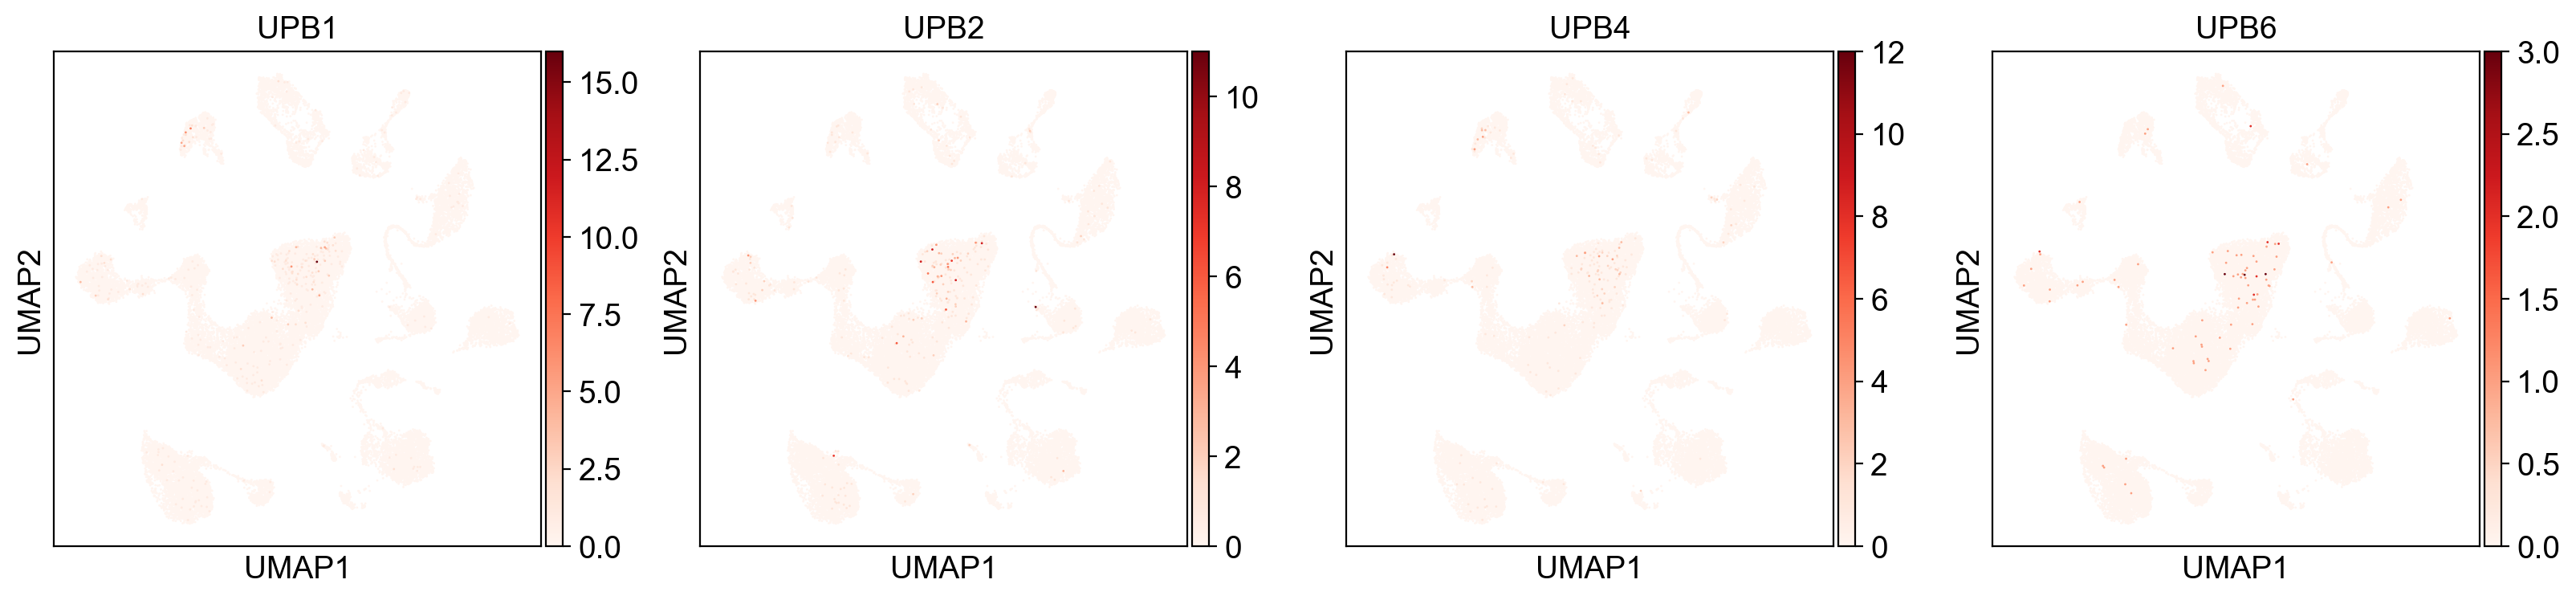

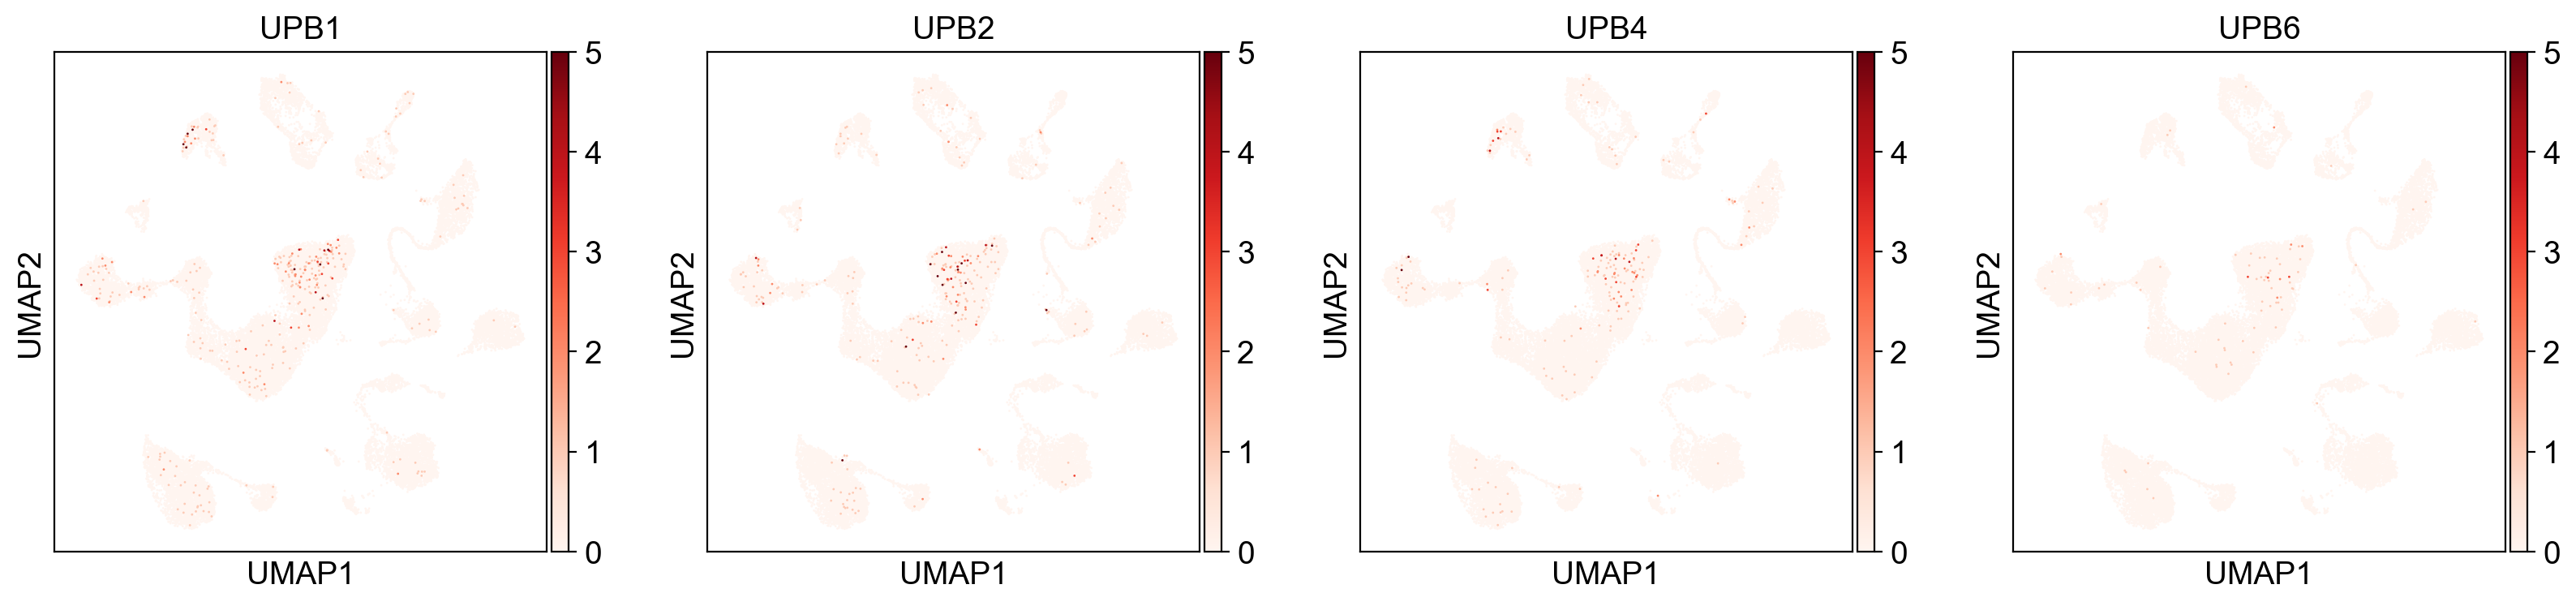

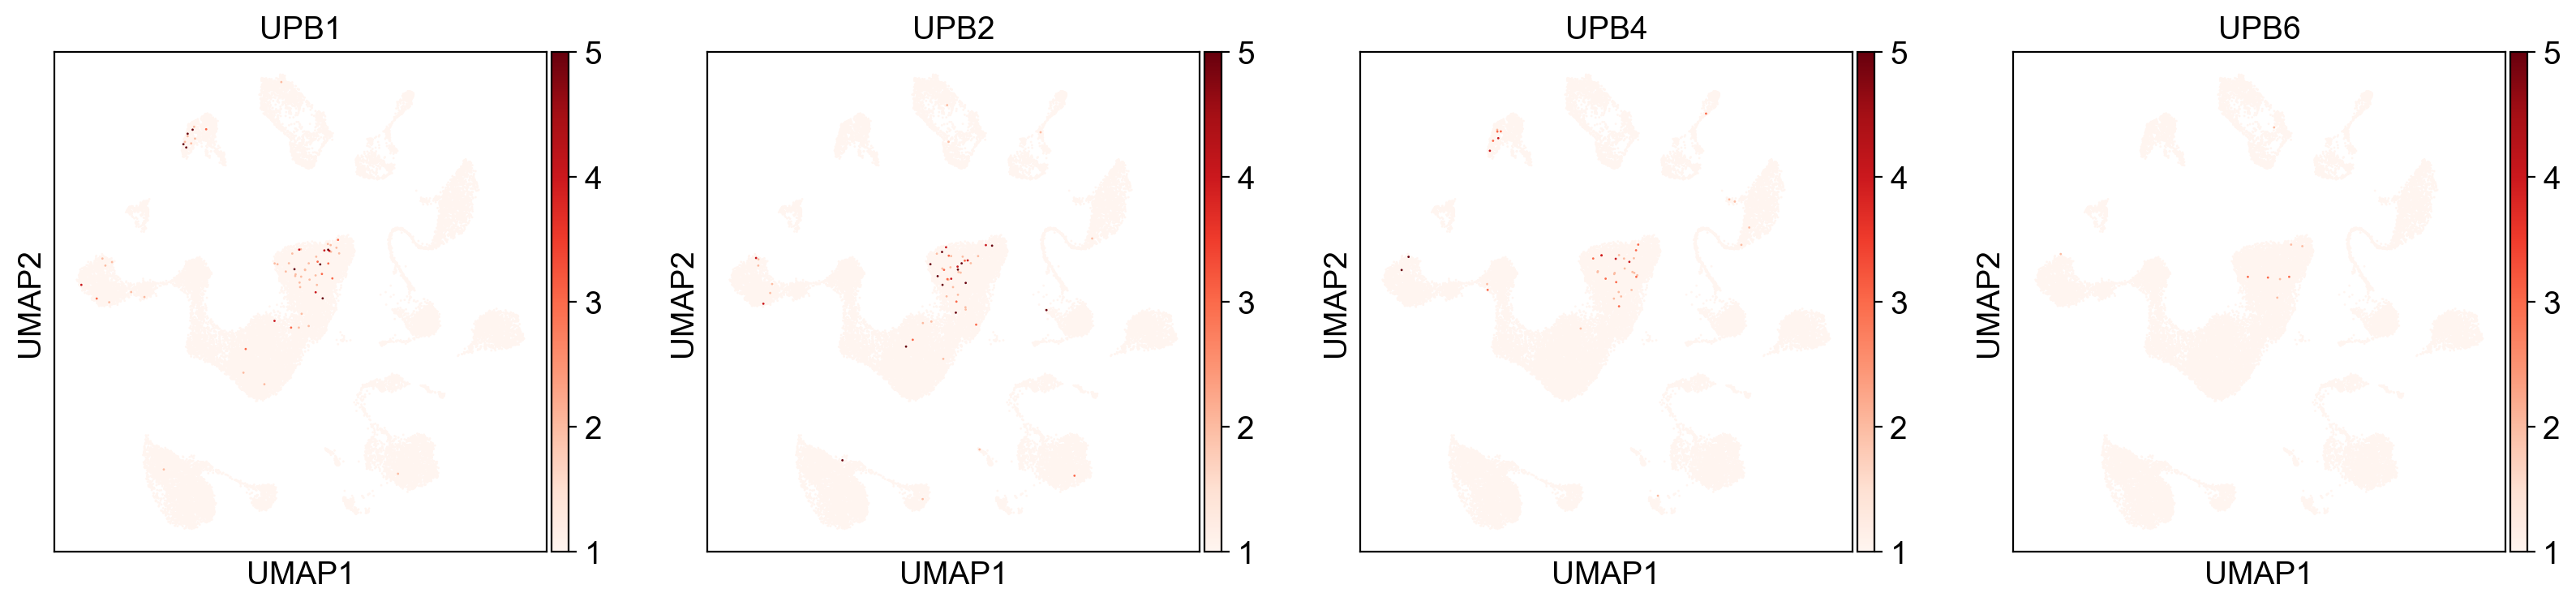

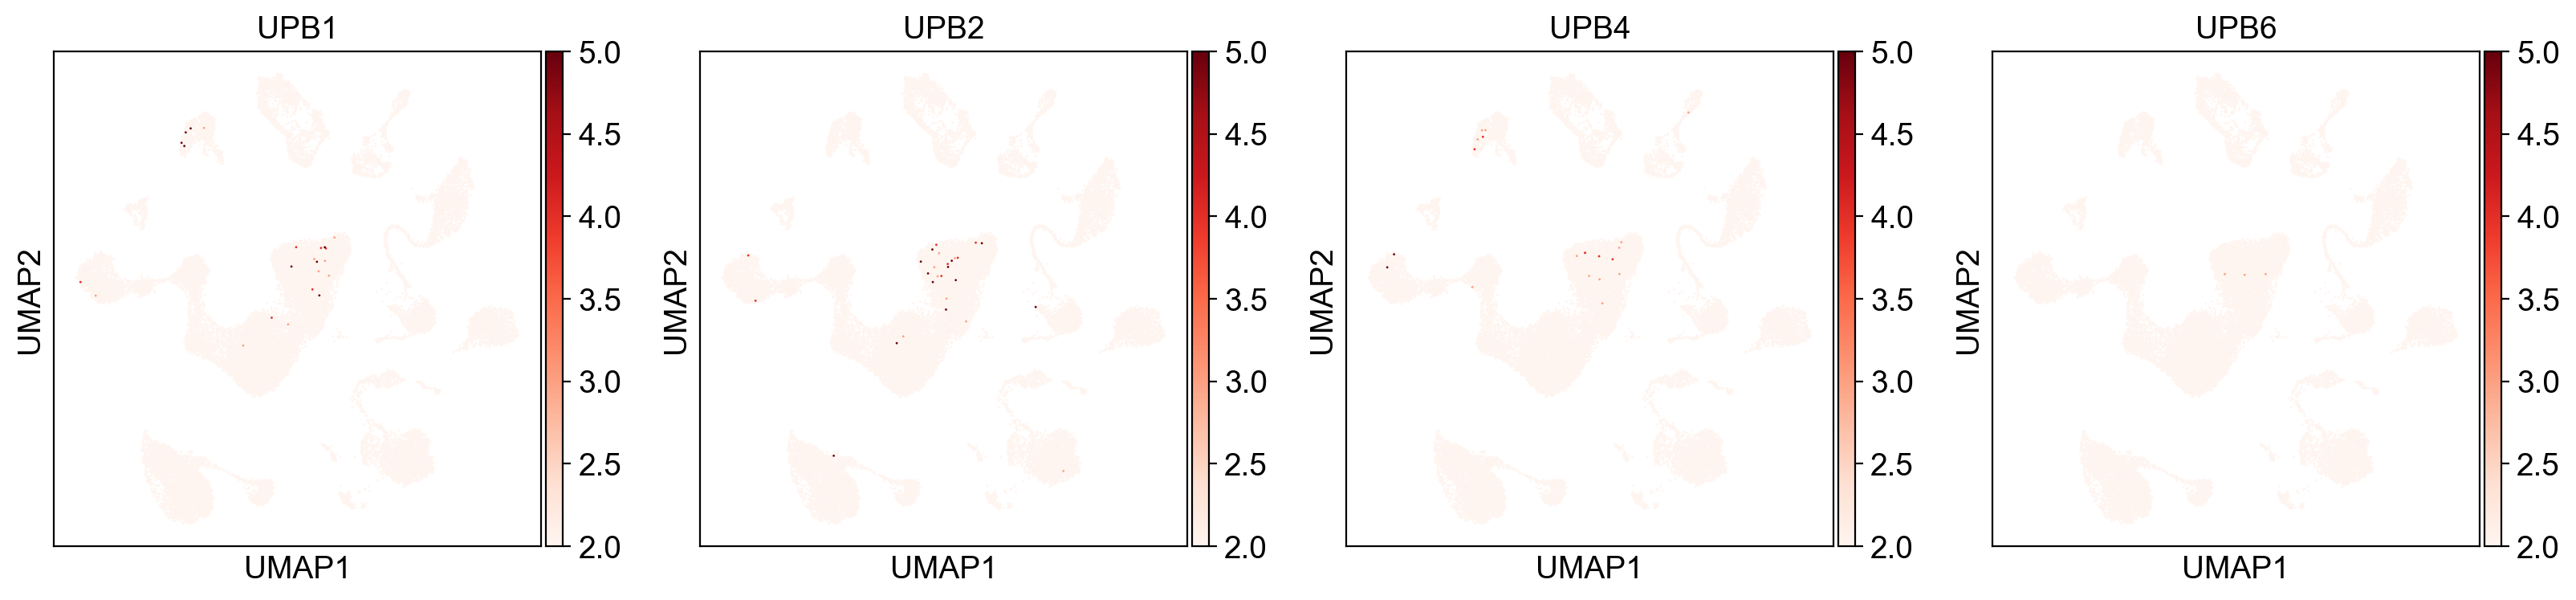

In [23]:
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmax=1)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds")
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmax=5)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmin=1, vmax=5)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmin=2, vmax=5)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


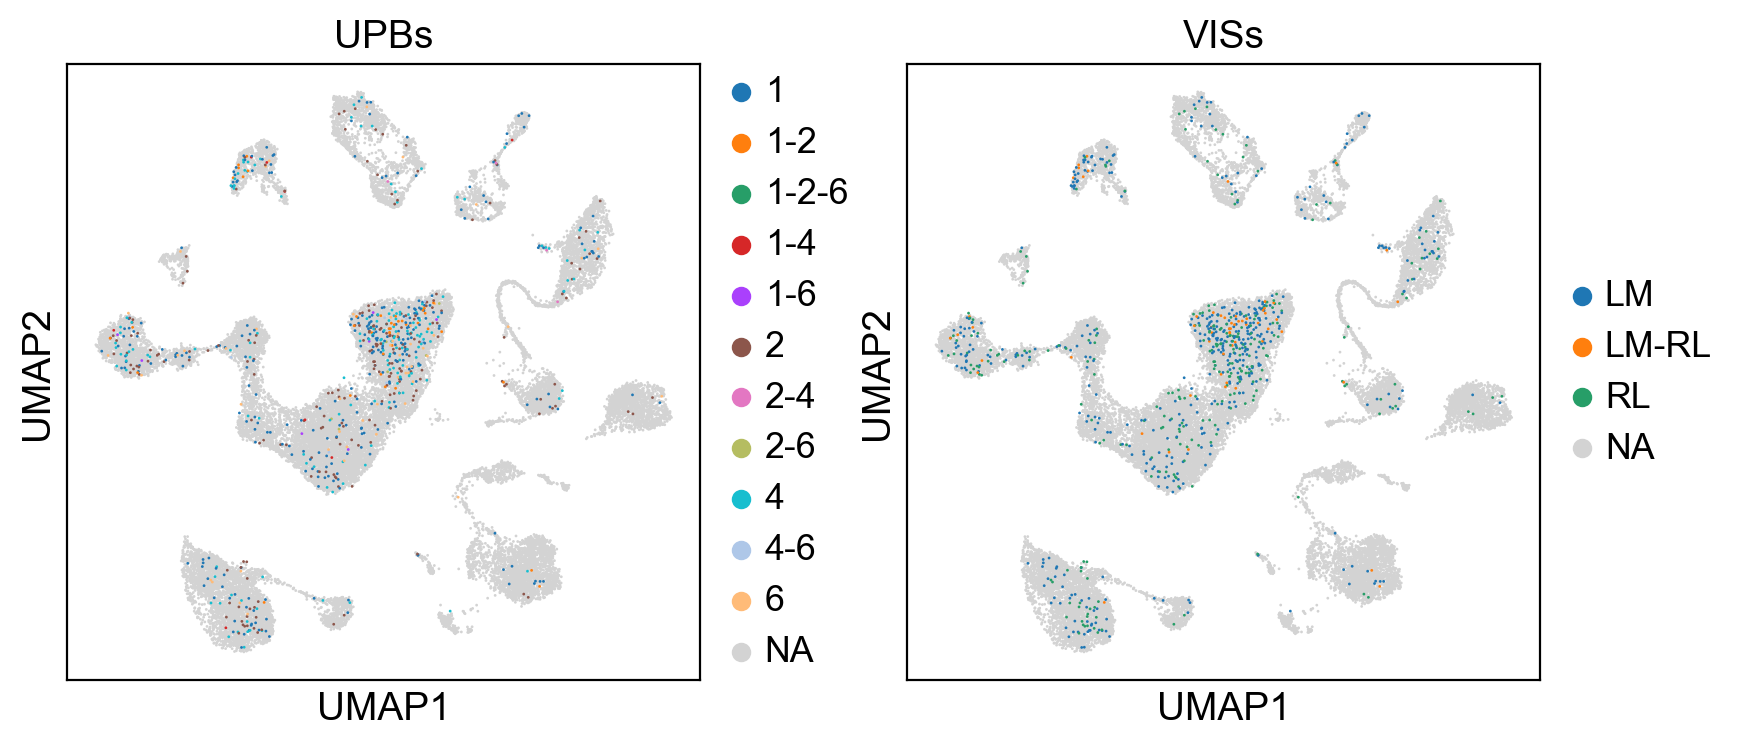

In [24]:
sc.pl.umap(adata, color=["UPBs", "VISs"])